# City of Cape Town - Property Valuation Tool

### Imports

In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle
%matplotlib inline

## Data Pre-processing and cleaning

In [2]:
#load json object
with open('capetown_2022.txt') as f:
    data = json.load(f)

In [3]:
data

[{'id': 'P110999173',
  'price': 'R 25 950 000',
  'location': 'Zwaanswyk',
  'address': '92 Zwaanswyk Road',
  'size': '11 910 m²',
  'property_type': 'Farm'},
 {'id': 'P111316089',
  'price': 'R 2 245 000',
  'location': 'Green Point',
  'address': None,
  'size': '56 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1',
  'Parking Spaces': '1'},
 {'id': 'P110566416',
  'price': 'R 1 880 000',
  'location': 'Cape Town City Centre',
  'address': None,
  'size': '37 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1'},
 {'id': 'P109398856',
  'price': 'R 7 800 000',
  'location': 'Green Point',
  'address': None,
  'size': '412 m²',
  'property_type': 'House',
  'Bedrooms': '3',
  'Bathrooms': '3.5',
  'Parking Spaces': '4'},
 {'id': 'P110242601',
  'price': 'R 10 750 000',
  'location': 'Waterfront',
  'address': None,
  'size': '105 m²',
  'property_type': 'Apartment',
  'Bedrooms': '2',
  'Bathrooms': '2',
  'Parking Spaces': '2'},
 {'id'

In [4]:
# get data into pandas dataframe
ct_data = pd.json_normalize(data=data) 
ct_data.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
0,P110999173,R 25 950 000,Zwaanswyk,92 Zwaanswyk Road,11 910 m²,Farm,NaN,NaN,NaN
1,P111316089,R 2 245 000,Green Point,None,56 m²,Apartment,1,1,1
2,P110566416,R 1 880 000,Cape Town City Centre,None,37 m²,Apartment,1,1,NaN
3,P109398856,R 7 800 000,Green Point,None,412 m²,House,3,3.5,4
4,P110242601,R 10 750 000,Waterfront,None,105 m²,Apartment,2,2,2


Looking at the data, there are a few things that need to be done. Property types such as farms, vacant land etc. need to be removed. For the purposes of this model, only property types such as apartments and houses will be considered.
The units need to be removed from the size column, and the 'R' needs to be removed from price.

In [5]:
#Removing vacant land, commercial and industrial properties
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Vacant Land'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Commercial Property'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Industrial Property'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Farm'], inplace = True)

# Remove 'R' and whitespace from price
ct_data['price'] = ct_data['price'].str.replace(r"[a-zA-Z]",'', regex=True)
ct_data['price'] = ct_data['price'].str.replace(' ', '', regex= True)

#Remove m2 from size
ct_data['size'] = ct_data['size'].str.replace(r'\D', '', regex=True)

ct_data.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
1,P111316089,2245000,Green Point,None,56,Apartment,1,1,1
2,P110566416,1880000,Cape Town City Centre,None,37,Apartment,1,1,NaN
3,P109398856,7800000,Green Point,None,412,House,3,3.5,4
4,P110242601,10750000,Waterfront,None,105,Apartment,2,2,2
5,P111185032,3450000,Wynberg Upper,None,241,House,1,1,1


In [6]:
# Taking a look at the data types of eacch column
ct_data.dtypes

id                object
price             object
location          object
address           object
size              object
property_type     object
Bedrooms          object
Bathrooms         object
Parking Spaces    object
dtype: object

Variables such as price, size, bedrooms, bathrooms and parking spaces have to be converted into numeric datatypes

In [7]:
#convert to numeric\
ct_data['price'] = pd.to_numeric(ct_data['price'])
ct_data['size'] = pd.to_numeric(ct_data['size'])
ct_data['Bedrooms'] = pd.to_numeric(ct_data['Bedrooms'])
ct_data['Bathrooms'] = pd.to_numeric(ct_data['Bathrooms'])
ct_data['Parking Spaces'] = pd.to_numeric(ct_data['Parking Spaces'])

ct_data.dtypes

id                 object
price             float64
location           object
address            object
size              float64
property_type      object
Bedrooms          float64
Bathrooms         float64
Parking Spaces    float64
dtype: object

In [8]:
#Taking a look at the number of rows
ct_data.count() # show us the number of rows

id                8644
price             8597
location          8644
address           3283
size              8056
property_type     8644
Bedrooms          8364
Bathrooms         8543
Parking Spaces    7219
dtype: int64

This suggests that there may be some missing data or nulls in the dataset.
The next steps will be to check what the number of nulls in each column are, and then try and replace the missing data using imputation 

In [9]:
ct_data.isnull().sum()

id                   0
price               47
location             0
address           5361
size               588
property_type        0
Bedrooms           280
Bathrooms          101
Parking Spaces    1425
dtype: int64

The important variables to try and impute would be price, size, number of bedrooms, bathrooms and parking spaces. <br>
The next step is to look at the summary statistics of the data and then decide on the best measure to use for imputing values


In [10]:
# Taking a look at some descriptive statistics
ct_data.describe() 

,price,size,Bedrooms,Bathrooms,Parking Spaces
count,8.597000e+03,8056.000000,8364.000000,8543.000000,7219.000000
mean,5.303907e+06,344.455189,2.533238,1.980306,2.222053
std,8.906688e+06,1720.465383,1.762869,1.537634,1.937960
min,2.000000e+05,13.000000,0.500000,0.500000,0.500000
25%,1.650000e+06,62.000000,2.000000,1.000000,1.000000
50%,2.600000e+06,105.500000,2.000000,2.000000,2.000000
75%,5.000000e+06,309.250000,3.000000,2.000000,2.000000
max,2.300000e+08,125762.000000,47.000000,45.000000,26.000000


In [11]:
ct_data.groupby(['Bedrooms'])['price'].median()

Bedrooms
0.5      1495000.0
1.0      1850000.0
1.5      1950000.0
2.0      2500000.0
2.5      1895000.0
3.0      3495000.0
3.5      6895000.0
4.0      6900000.0
4.5      5715000.0
5.0      8695000.0
5.5      1850000.0
6.0      9200000.0
7.0     15250000.0
8.0     10500000.0
9.0      9400000.0
10.0     7245000.0
11.0     8999000.0
12.0    11995000.0
13.0    18475000.0
14.0    12872500.0
15.0     8500000.0
16.0     8900000.0
17.0     3850000.0
18.0    14700000.0
19.0    41990000.0
21.0     6995000.0
28.0    13200000.0
30.0    39500000.0
47.0           NaN
Name: price, dtype: float64

In [12]:
ct_data.groupby(['Bathrooms'])['price'].median()

Bathrooms
0.50      1979000.0
1.00      1695000.0
1.25      2250000.0
1.50      2495000.0
2.00      3500000.0
2.50      6750000.0
3.00      5875000.0
3.50     10500000.0
4.00      9000000.0
4.50     17500000.0
5.00     14500000.0
5.50     24950000.0
6.00     18844500.0
6.50     28200000.0
7.00     18622500.0
7.50     35000000.0
8.00     17500000.0
8.50     23500000.0
9.00     20250000.0
9.50     56000000.0
10.00    12850000.0
11.00    13847500.0
12.00    11000000.0
12.50    28000000.0
13.00    43500000.0
14.00    14075000.0
16.00    15500000.0
16.50    25000000.0
18.00    14700000.0
19.50    41990000.0
30.00    39500000.0
45.00           NaN
Name: price, dtype: float64

In [13]:
ct_data.groupby(['Parking Spaces'])['price'].median()

Parking Spaces
0.5      1210000.0
1.0      1995000.0
1.5      4995000.0
2.0      4450000.0
2.5      2995000.0
3.0      3995000.0
4.0      6500000.0
4.5      2350000.0
5.0      3695000.0
6.0      4795000.0
7.0      6995000.0
8.0      7495000.0
9.0      8347500.0
10.0     8825000.0
11.0    24475000.0
12.0    18500000.0
13.0    23000000.0
14.0    71500000.0
15.0     9000000.0
16.0    15650000.0
17.0    17423999.5
18.0    11250000.0
20.0     1199000.0
26.0     7923000.0
Name: price, dtype: float64

In [14]:
ct_data.groupby(['size'])['price'].mean()

size
13.0        1.495000e+06
14.0        6.500000e+05
17.0        4.500000e+05
19.0        8.949998e+05
20.0        5.463333e+05
                ...     
17587.0     2.500000e+07
24671.0     6.500000e+07
37035.0     6.495000e+06
39243.0     1.600000e+07
125762.0    8.750000e+06
Name: price, Length: 1118, dtype: float64

Outliers need to be detected and possibly removed

<AxesSubplot:xlabel='price'>

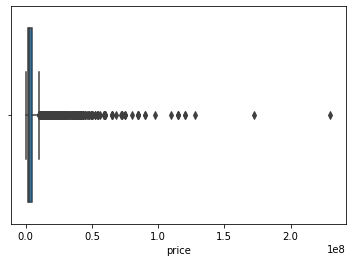

In [15]:
sns.boxplot(x=ct_data['price'])

<AxesSubplot:xlabel='size'>

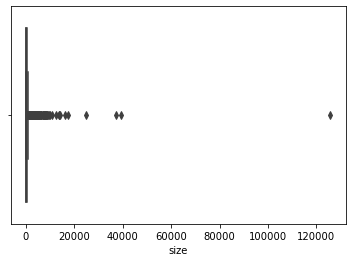

In [16]:
sns.boxplot(x=ct_data['size'])

<AxesSubplot:xlabel='Bedrooms'>

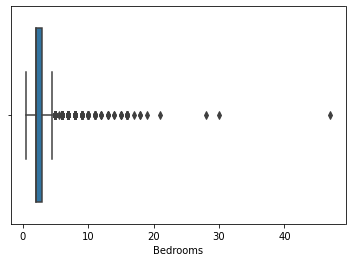

In [17]:
sns.boxplot(x=ct_data['Bedrooms'])

<AxesSubplot:xlabel='Bathrooms'>

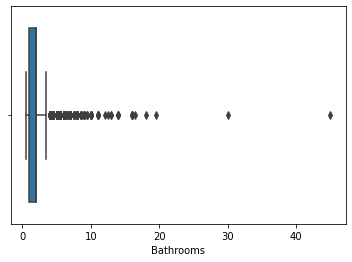

In [18]:
sns.boxplot(x=ct_data['Bathrooms'])

<AxesSubplot:xlabel='Parking Spaces'>

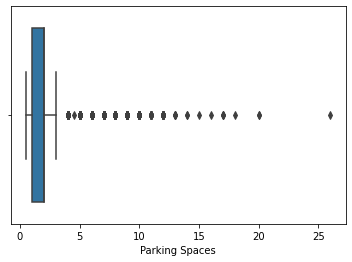

In [19]:
sns.boxplot(x=ct_data['Parking Spaces'])

In [20]:
#imputing null values for price and size using mean
ct_data['price'] = ct_data['price'].fillna(ct_data.groupby('size')['price'].transform('mean'))
ct_data['size'] = ct_data['size'].fillna(ct_data.groupby('price')['size'].transform('mean'))

In [21]:
#imputing null values for bedrooms, bathrooms and parking spaces using the median
ct_data['Bedrooms'] = ct_data['Bedrooms'].fillna(ct_data.groupby('price')['Bedrooms'].transform('median'))
ct_data['Bathrooms'] = ct_data['Bathrooms'].fillna(ct_data.groupby('price')['Bathrooms'].transform('median'))
ct_data['Parking Spaces'] = ct_data['Parking Spaces'].fillna(ct_data.groupby('price')['Parking Spaces'].transform('median'))

In [22]:
ct_data.isnull().sum()

id                   0
price               16
location             0
address           5361
size                73
property_type        0
Bedrooms            31
Bathrooms           14
Parking Spaces     154
dtype: int64

In [23]:
ct_data['price'].fillna((ct_data['price'].mean()), inplace=True)
ct_data['size'] = ct_data['size'].fillna(ct_data.groupby('price')['size'].transform('mean'))
ct_data['size'].fillna((ct_data['size'].mean()), inplace=True)
ct_data['Bedrooms'] = ct_data['Bedrooms'].fillna(ct_data.groupby('price')['Bedrooms'].transform('median'))
ct_data['Bathrooms'] = ct_data['Bathrooms'].fillna(ct_data.groupby('price')['Bathrooms'].transform('median'))
ct_data['Parking Spaces'] = ct_data['Parking Spaces'].fillna(ct_data.groupby('price')['Parking Spaces'].transform('median'))
ct_data['Bedrooms'].fillna((ct_data['Bedrooms'].median()), inplace=True)
ct_data['Bathrooms'].fillna((ct_data['Bathrooms'].median()), inplace=True)
ct_data['Parking Spaces'].fillna((ct_data['Parking Spaces'].median()), inplace=True)
ct_data.isnull().sum()

id                   0
price                0
location             0
address           5361
size                 0
property_type        0
Bedrooms             0
Bathrooms            0
Parking Spaces       0
dtype: int64

In [24]:
#Encoding categorical features such as location and property type
ct_data["location"].value_counts()

Cape Town City Centre    970
Sea Point                698
Woodstock                355
Green Point              348
Camps Bay                272
                        ... 
Trovato                    1
Windermere                 1
Constantia Heights         1
Welcome                    1
Capricorn                  1
Name: location, Length: 150, dtype: int64

In [25]:
ct_data["property_type"].value_counts()

Apartment    5338
House        3026
Townhouse     280
Name: property_type, dtype: int64

In [26]:
ct_data_encode = pd.get_dummies(ct_data, columns=["location", "property_type"], drop_first=True)
ct_data_encode.head()

,id,price,address,size,Bedrooms,Bathrooms,Parking Spaces,location_Alphen,location_Athlone,location_Bakoven,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
1,P111316089,2245000.0,None,56.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,P110566416,1880000.0,None,37.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,P109398856,7800000.0,None,412.0,3.0,3.5,4.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,P110242601,10750000.0,None,105.0,2.0,2.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,P111185032,3450000.0,None,241.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [27]:
ct_data.groupby(['location'])['price'].median()

location
Adriaanse          650000.0
Alphen            8000000.0
Athlone           1687500.0
Bakoven          17500000.0
Bantry Bay       13992500.0
                    ...    
Wynberg            850000.0
Wynberg Upper     2172500.0
Zeekoevlei        2800000.0
Zonnebloem        1780000.0
Zwaanswyk        17225000.0
Name: price, Length: 150, dtype: float64

In [28]:
#The address column will not be used
ct_data_encode= ct_data_encode.drop(columns = ['address'])

In [29]:
#Function to get rid of outliers
def get_outliers(X, outliers_fraction=0.25):
    clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
    clf.fit(X)
    result = clf.predict(X)
    return result

In [30]:
ct_data2= ct_data_encode[get_outliers(ct_data_encode.drop(columns=['id']), 0.15)==1]
ct_data2.describe()

,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Alphen,location_Athlone,location_Bakoven,location_Bantry Bay,location_Bel Ombre,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
count,4.076000e+03,4076.000000,4076.000000,4076.000000,4076.000000,4076.0,4076.000000,4076.000000,4076.000000,4076.000000,...,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000,4076.000000
mean,4.746376e+06,294.479016,2.362733,1.851018,1.955716,0.0,0.004907,0.001717,0.012267,0.000245,...,0.002944,0.000245,0.040972,0.015211,0.014720,0.001963,0.026742,0.000736,0.309863,0.031894
std,7.824437e+06,946.054402,1.553934,1.309413,1.711115,0.0,0.069885,0.041411,0.110088,0.015663,...,0.054186,0.015663,0.198249,0.122406,0.120446,0.044264,0.161348,0.027123,0.462494,0.175739
min,2.000000e+05,14.000000,0.500000,0.500000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595000e+06,60.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.495000e+06,94.000000,2.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.499925e+06,234.250000,3.000000,2.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.725000e+08,39243.000000,21.000000,18.000000,17.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualizing Data & Exploratory Analyses


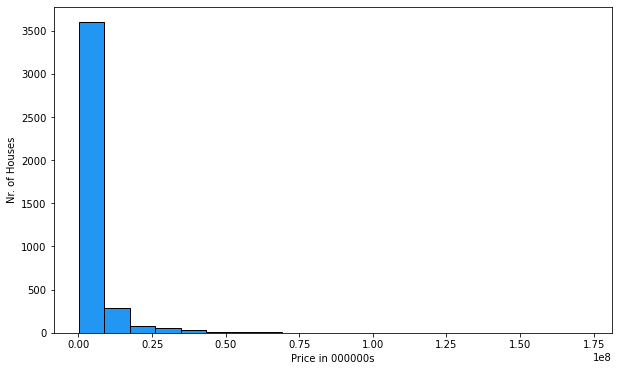

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(ct_data2['price'], bins=20, ec='black', color='#2196f3')
plt.xlabel('Price in 000000s')
plt.ylabel('Nr. of Houses')
plt.show()

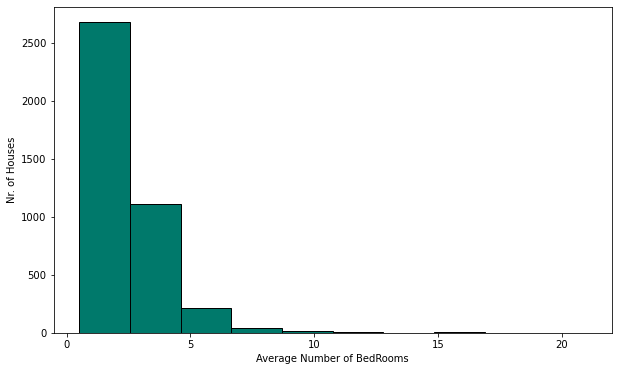

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(ct_data2['Bedrooms'], ec='black', color='#00796b')
plt.xlabel('Average Number of BedRooms')
plt.ylabel('Nr. of Houses')
plt.show()

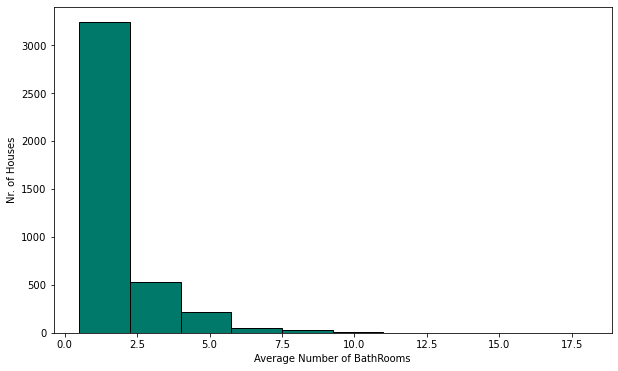

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(ct_data2['Bathrooms'], ec='black', color='#00796b')
plt.xlabel('Average Number of BathRooms')
plt.ylabel('Nr. of Houses')
plt.show()

In [34]:
#Looking at correlations between variables
ct_data.corr()

,price,size,Bedrooms,Bathrooms,Parking Spaces
price,1.000000,0.212465,0.393487,0.559057,0.369213
size,0.212465,1.000000,0.203057,0.228629,0.266394
Bedrooms,0.393487,0.203057,1.000000,0.841125,0.556636
Bathrooms,0.559057,0.228629,0.841125,1.000000,0.535874
Parking Spaces,0.369213,0.266394,0.556636,0.535874,1.000000


In [35]:
def plot_corrmatrix(data):  
    mask = np.zeros_like(ct_data.corr())
    triangle_indices = np.triu_indices_from(mask)
    mask[triangle_indices] = True

    plt.figure(figsize=(16,10))
    sns.heatmap(ct_data.corr(), mask=mask, annot=True, annot_kws={"size": 14})
    sns.set_style('white')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

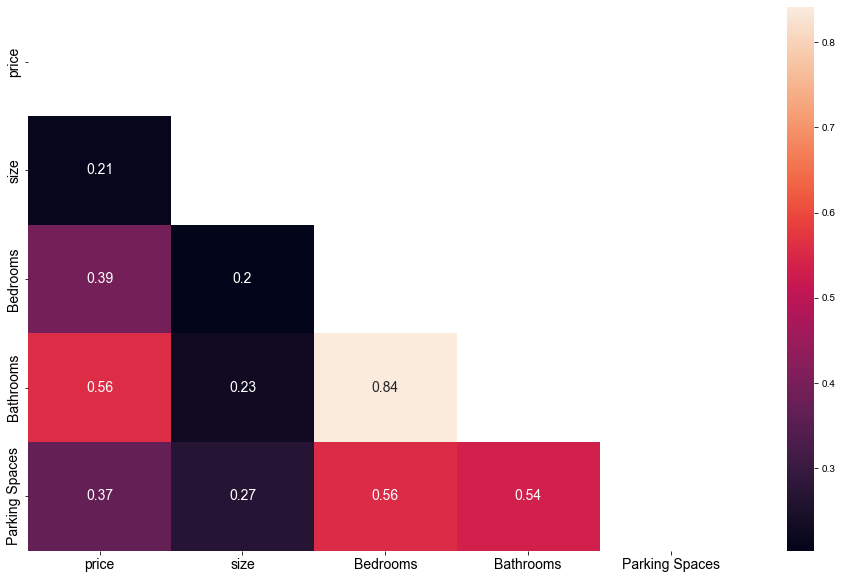

In [36]:
plot_corrmatrix(ct_data)

# Model 

In [37]:
prices = np.log(ct_data2['price']) # Use log prices
features = ct_data2.drop(columns = ['price', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 10) 

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

print('Training data r-squared:', model_1.score(X_train, y_train))
print('Test data r-squared:', model_1.score(X_test, y_test))

print('Intercept', model_1.intercept_)
pd.DataFrame(data=model_1.coef_, index=X_train.columns, columns=['coef'])

X_train shape: (2445, 155)
X_test shape: (816, 155)
y_train shape: (2445,)
y_test shape: (816,)
X_val shape: (2445,)
y val shape: (816,)
Training data r-squared: 0.8360767281779711
Test data r-squared: 0.7585646060669164
Intercept 12.417831047895845


,coef
size,7.568083e-05
Bedrooms,8.189912e-02
Bathrooms,2.011508e-01
Parking Spaces,4.158282e-02
location_Alphen,-2.006528e-11
...,...
location_Zeekoevlei,9.633178e-01
location_Zonnebloem,1.475843e+00
location_Zwaanswyk,1.925403e+00
property_type_House,3.035408e-01


In [38]:
#Random Forest Regressor
model2 = RandomForestRegressor(n_estimators=300, max_features='sqrt')
results = model2.fit(X_train, y_train)

print('Training data r-squared:', model2.score(X_train, y_train))
print('Test data r-squared:', model2.score(X_test, y_test))

#print('Intercept', model2.intercept_)
#pd.DataFrame(data=model2.coef_, index=X_train.columns, columns=['coef'])

Training data r-squared: 0.9756556190222945
Test data r-squared: 0.8350113728962716


In [39]:
# Predicting the Test set results
y_pred = model2.predict(X_val)

In [40]:
# Evaluating the Algorithm on validation dataset
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 0.2569633551196259
Mean Squared Error: 0.1303567779079677
Root Mean Squared Error: 0.36104955048852744


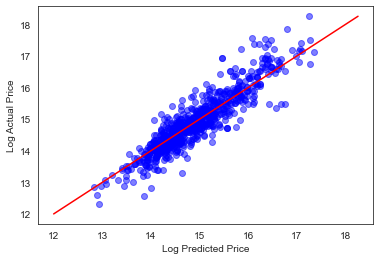

In [41]:
actual_values = y_val
plt.scatter(y_pred, actual_values, alpha=.5,
            color='b')
plt.xlabel('Log Predicted Price')
plt.ylabel('Log Actual Price')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    model2.score(X_val, y_val),
                    mean_squared_error(y_val, y_pred))
plt.annotate(text=overlay,xy=(12.1,10.6),size='x-large')
# Now add the perfect prediction line
diagonal = np.linspace(12, np.max(y_val), 100)
plt.plot(diagonal, diagonal, '-r')
plt.show()

In [42]:
#What features are the most important predictors?

model_RF = RandomForestRegressor(n_estimators=300, max_features='sqrt').fit(features, prices)
fitted_vals = model_RF.predict(features)
MSE = mean_squared_error(prices, fitted_vals)
RMSE = np.sqrt(MSE)

feature_list = list(features.columns)
# Get numerical feature importances
importances = list(model_RF.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: size                 Importance: 0.22
Variable: Bathrooms            Importance: 0.22
Variable: Parking Spaces       Importance: 0.09
Variable: Bedrooms             Importance: 0.08
Variable: location_Camps Bay   Importance: 0.04
Variable: property_type_House  Importance: 0.03
Variable: location_Bantry Bay  Importance: 0.02
Variable: location_Clifton     Importance: 0.02
Variable: location_Waterfront  Importance: 0.02
Variable: location_Wynberg     Importance: 0.02
Variable: location_Belhar      Importance: 0.01
Variable: location_Bishopscourt Importance: 0.01
Variable: location_Cape Town City Centre Importance: 0.01
Variable: location_Constantia  Importance: 0.01
Variable: location_De Waterkant Importance: 0.01
Variable: location_Fresnaye    Importance: 0.01
Variable: location_Green Point Importance: 0.01
Variable: location_Llandudno   Importance: 0.01
Variable: location_Maitland    Importance: 0.01
Variable: location_Mouille Point Importance: 0.01
Variable: location_Pelican

## Saving the model

In [43]:
Pkl_Filename = "CTHouse_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model2, file)

In [45]:

features.mean()

size                       294.479016
Bedrooms                     2.362733
Bathrooms                    1.851018
Parking Spaces               1.955716
location_Alphen              0.000000
                              ...    
location_Zeekoevlei          0.001963
location_Zonnebloem          0.026742
location_Zwaanswyk           0.000736
property_type_House          0.309863
property_type_Townhouse      0.031894
Length: 155, dtype: float64

In [46]:
property_stats = features.mean().values.reshape(1, 155)

In [49]:
#Function to input features and get log estimate of price, with confidence interval
def get_log_estimate(size,
                    bed,
                    bath,
                    parking,
                    high_confidence=True):
    
    # Configure property
    property_stats[0][0] = size
    property_stats[0][1] = bed
    property_stats[0][2] = bath
    property_stats[0][3] = parking

    #Reloading model
    with open(Pkl_Filename, 'rb') as file:  
        CT_Model = pickle.load(file)
   
    # Make prediction
    log_estimate = CT_Model.predict(property_stats)[0]
    
    # Calc Range 
    if high_confidence:
        upper_bound = log_estimate + 2*RMSE
        lower_bound = log_estimate - 2*RMSE
        interval = 95
    else:
        upper_bound = log_estimate + RMSE
        lower_bound = log_estimate - RMSE
        interval = 68
    
    return log_estimate, upper_bound, lower_bound, interval

In [50]:
get_log_estimate(60, 1, 1, 1, True)

/Users/sohanasingh/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(14.176798873757821, 14.451820625232013, 13.90177712228363, 95)

In [51]:
def get_estimate(size, bath, bed, parking, high_confidence = False):
    """Estimate the price of a property in Cape Town.
    
    Keyword arguments:
    size -- size of property
    bath -- number of bathrooms in the property.
    bed -- number of bedrooms in the property
    park -- number of parking spaces on the property
    large_range -- True for a 95% prediction interval, False for a 68% interval.
    
    """
    
    
    if size < 10 or bath < 1 or bed < 1:
        print('That is unrealistic. Try again.')
        return

    log_est, upper, lower, conf = get_log_estimate(size, 
                                                   bed, 
                                                   bath,
                                                   parking,
                                                   high_confidence)

    # Convert log to Rands
    rand_est = np.e**log_est 
    rand_hi = np.e**upper 
    rand_low = np.e**lower

    # Round the dollar values to nearest thousand
    rounded_est = np.around(rand_est, -3)
    rounded_hi = np.around(rand_hi, -3)
    rounded_low = np.around(rand_low, -3)

    return rounded_est, rounded_hi, rounded_low, conf
    #print(f'The estimated property value is {rounded_est}.')
    #print(f'At {conf}% confidence the valuation range is')
    #print(f'Rands {rounded_low} at the lower end to Rands {rounded_hi} at the high end.')

In [52]:
get_estimate(30, 1, 1, 1)

/Users/sohanasingh/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(1122000.0, 1287000.0, 978000.0, 68)

# Creating a Flask App

In [53]:
from flask import Flask, request, jsonify, url_for, render_template
import uuid
import os

In [54]:
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/prediction')
def predict():
    size = int(request.args.get('size'))
    bed = int(request.args.get('bed'))
    bath = int(request.args.get('bath'))
    parking = int(request.args.get('parking'))
    rounded_est, rounded_hi, rounded_low, conf = get_estimate(size = size, bed = bed, bath = bath, parking = parking, high_confidence = True)
    return render_template('prediction.html', prediction = f'The estimated property value is R{rounded_est}, At {conf}% confidence the valuation range is R{rounded_low} at the lower end to R{rounded_hi} at the high end.')

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2022 22:09:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 22:09:54] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 22:09:55] "GET /favicon.ico HTTP/1.1" 404 -
/Users/sohanasingh/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
127.0.0.1 - - [05/Jun/2022 22:10:29] "GET /prediction?size=10&bed=1&bath=1&parking=0&submit=Submit HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 22:10:29] "GET /static/css/style.css HTTP/1.1" 304 -
/Users/sohanasingh/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
127.0.0.1 - - [05/Jun/2022 22:11:16] "GET /prediction?size=100&bed=2&bath=1&parking=1&submit=Submit HTTP/1.1" 200 -
127.0.0.1 - - 